In [1]:
import sys
sys.path.insert(0, r"K:/Thesis/codes/crypto_project")
sys.path.insert(0, r"E:/Thesis/crypto_project")
import os
import sqlite3
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

DATABASE_LOCATION = r"E:/Thesis/database"
from factor_model.model_update.database_generators import (
    FACTOR_MODEL_ESTIMATES,
    FIX_SET_OF_HALF_LIFES,
    SPECIFIC_RISK
)


In [2]:
import multiprocessing
from factor_model.risk_calculations.specific_risk import (
    generate_raw_specific_risk,
    generate_raw_portfolio_specific_risk
)
from factor_model.risk_calculations.core_universe_portfolio import generate_market_portfolio

In [3]:
with sqlite3.connect(os.path.join(DATABASE_LOCATION, FACTOR_MODEL_ESTIMATES)) as conn:
    full_specific_returns = pd.read_sql_query(f"SELECT * FROM specific_returns", conn)

In [4]:
dates = list(full_specific_returns["date"].unique())[1:]
FIX_SET_OF_HALF_LIFES = sorted(list(range(10, 3 * 365, 30)) + [365])
risk_calculation_parameters = {
    "correlation_half_life": 730,  # days
    "variance_half_life": 365,  # days
    "specific_risk_half_life": 365,
    "date": "2023-03-04",
    "minimum_history_spec_ret": 730
}

In [7]:
def multi_process_calc(temp_half_life):
    symbols = set(full_specific_returns["ticker"])
    risk_calculation_parameters = {"specific_risk_half_life": temp_half_life}
    risk_for_half_life = list()
    for symbol in symbols:
        specific_returns_temp = full_specific_returns[
            (full_specific_returns["ticker"] == symbol)
        ].copy()
        ewma_temp = specific_returns_temp[["date"]].copy()
        ewma_temp[symbol] = (
            specific_returns_temp["specific_return"]
            .ewm(halflife=risk_calculation_parameters["specific_risk_half_life"])
            .std()
        )
        ewma_temp["symbol"] = symbol
        risk_for_half_life.append(ewma_temp.rename(columns={symbol:"specific_risk"}))
    return pd.concat(risk_for_half_life, axis=0)

In [8]:
all_core_spec_risk = {}

for temp_half_life in tqdm(FIX_SET_OF_HALF_LIFES):
    all_core_spec_risk[temp_half_life] = multi_process_calc(temp_half_life)
    all_core_spec_risk[temp_half_life].set_index(["date", "symbol"],inplace=True)

  0%|          | 0/38 [00:00<?, ?it/s]

In [9]:
# symbols = set(full_specific_returns["ticker"])

# all_core_spec_risk = {}

# with multiprocessing.Pool(processes=4) as pool:
#     # res_struct = pool.map(multi_process_calc, FIX_SET_OF_HALF_LIFES)
#     res_struct = list(tqdm(pool.imap(multi_process_calc, FIX_SET_OF_HALF_LIFES)))
#     for df, half_life  in zip(res_struct, FIX_SET_OF_HALF_LIFES):
#         all_core_spec_risk[half_life] = df

In [54]:
# for key in all_core_spec_risk.keys():
#     all_core_spec_risk[key].to_csv( os.path.join(DATABASE_LOCATION, f"core_spec_risk_{key}.csv"), index=False)

In [75]:
# all_core_spec_risk = dict()
# for key in FIX_SET_OF_HALF_LIFES:
#     all_core_spec_risk[key].pd.read_csv(os.path.join(DATABASE_LOCATION, f"core_spec_risk_{key}.csv"))
#     all_core_spec_risk[key].set_index(["date", "symbol"],inplace=True)

In [88]:
all_combined_specific_risk_estimates = list()

for date in tqdm(dates):
    # 1. gather exposures
    with sqlite3.connect(
        os.path.join(DATABASE_LOCATION, FACTOR_MODEL_ESTIMATES)
    ) as conn:
        exposure = pd.read_sql_query(
            f"SELECT ticker, transformed_market_cap, core_universe FROM exposures where date = '{date}'",
            conn,
        )

    # 2. identify universe_info
    market_portfolio = generate_market_portfolio(exposure)

    for half_life in FIX_SET_OF_HALF_LIFES:
        # 3. grab relevant spec risks
        tempd_df = all_core_spec_risk[half_life][
            all_core_spec_risk[half_life].index.get_level_values("date") == date
        ].copy()
        tempd_df.reset_index(inplace=True)
        tempd_df.set_index("symbol", inplace=True)
        tempd_df.dropna(inplace=True)

        all_combined_specific_risk_estimates.append(
            pd.DataFrame(
                {
                    "date": [date],
                    "half_life": [half_life],
                    "specific_risk": generate_raw_portfolio_specific_risk(
                        tempd_df.to_dict()["specific_risk"], market_portfolio
                    ),
                }
            )
        )

  0%|          | 0/2128 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [89]:
temp_res = pd.concat(all_combined_specific_risk_estimates)

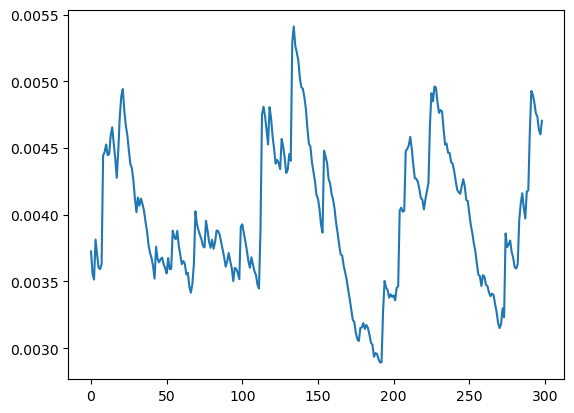

In [136]:
import matplotlib.pyplot as plt

te_series = temp_res[temp_res["half_life"]==10].copy()
plt.plot(range(0,len(te_series)),te_series["specific_risk"]);